<a href="https://colab.research.google.com/github/RifaldiAchmad/Internship-Taudata/blob/main/01%20-%20BERT" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [16]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import Dataset
from tqdm import tqdm
import torch
import pandas as pd
import pickle
import re

In [3]:
! git clone https://github.com/RifaldiAchmad/Internship-Taudata.git

Cloning into 'Internship-Taudata'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 58 (delta 19), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 6.73 MiB | 8.56 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [4]:
# Load dataset
data = pd.read_csv('/content/Internship-Taudata/data/main_data.csv')
data

In [5]:
# Remove special characters, convert to lowercase, and trim spaces
data['title'] = data['title'].astype(str).str.replace('[^a-zA-Z0-9\s]', '', regex=True)
data['title'] = data['title'].str.lower()
data['title'] = data['title'].str.replace('\s+', ' ', regex=True).str.strip()

# Remove emoticons
def remove_emoticons(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticon wajah
                               u"\U0001F300-\U0001F5FF"  # Simbol & ikon
                               u"\U0001F680-\U0001F6FF"  # Transportasi & simbol
                               u"\U0001F1E0-\U0001F1FF"  # Bendera (indikator regional)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['title'] = data['title'].apply(remove_emoticons)

# Load stopwords
with open('/content/Internship-Taudata/stopwords_id.txt', 'r', encoding='utf-8') as file:
    stopwords_id = set(file.read().splitlines())

data['title'] = data['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_id]))

In [8]:
# Prepare label encoding
label_mapping = {label: idx for idx, label in enumerate(data['label'].unique())}
data['label'] = data['label'].map(label_mapping)

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['title'],
    data['label'],
    test_size=0.2,
    random_state=42,
    stratify=data['label']  # Ensure class distribution is maintained
)

In [9]:
# Tokenizer and dataset class
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [10]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

In [12]:
# Define the compute_metrics function using classification_report
def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=-1)  # Get the predicted labels

    # Generate the classification report
    report = classification_report(labels, preds, output_dict=True, zero_division=0)

    # Return a dictionary of metrics
    # Extract the macro average (overall metrics) and per-class metrics
    return {
        'accuracy': report['accuracy'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1': report['macro avg']['f1-score']
    }

In [13]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    load_best_model_at_end=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=3.437668958850191e-05,
    seed=42
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
# Set up cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
# Initialize variables to store aggregated results
all_metrics = []
all_confusion_matrices = None
fold = 1

In [17]:
for train_idx, val_idx in skf.split(data['title'], data['label']):
    # Split data into train and validation sets for the current fold
    train_texts = data['title'].iloc[train_idx]
    train_labels = data['label'].iloc[train_idx]
    val_texts = data['title'].iloc[val_idx]
    val_labels = data['label'].iloc[val_idx]

    # Create datasets for the current fold
    train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
    val_dataset = CustomDataset(val_texts, val_labels, tokenizer)

    # Load model (re-initialize for each fold)
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-multilingual-cased', num_labels=len(label_mapping)
    )

    # Trainer for the current fold
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train and evaluate the model
    trainer.train()
    eval_results = trainer.evaluate()

    # Save the trained model for the current fold
    model_filename = f"bert_model_fold_{fold}.pkl"
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model for fold {fold} saved as {model_filename}")

    # Aggregate metrics
    all_metrics.append(eval_results)

    # Generate predictions and update confusion matrix
    val_preds = trainer.predict(val_dataset)
    pred_labels = val_preds.predictions.argmax(axis=-1)
    cm = confusion_matrix(val_labels, pred_labels, labels=range(len(label_mapping)))

    if all_confusion_matrices is None:
        all_confusion_matrices = cm
    else:
        all_confusion_matrices += cm

    fold += 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-4ce56841c4f9>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.357800,0.452117,0.877823,0.909086,0.862052,0.868552
2,0.191600,0.319174,0.916496,0.924025,0.911643,0.916581
3,0.180700,0.361832,0.922313,0.924772,0.921748,0.923136


Model for fold 6 saved as bert_model_fold_6.pkl


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-4ce56841c4f9>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.431900,0.395830,0.875385,0.897464,0.861636,0.871468
2,0.275100,0.317833,0.911674,0.916530,0.909152,0.912077
3,0.142100,0.321024,0.925710,0.930040,0.922839,0.926020


Model for fold 7 saved as bert_model_fold_7.pkl


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-4ce56841c4f9>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.449000,0.315944,0.913728,0.916997,0.914540,0.914760
2,0.302600,0.293058,0.928107,0.926525,0.930934,0.928579
3,0.188200,0.287655,0.936666,0.940782,0.935492,0.937999


Model for fold 8 saved as bert_model_fold_8.pkl


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-4ce56841c4f9>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.353500,0.380571,0.897980,0.907206,0.894496,0.899324
2,0.156100,0.324091,0.918179,0.929417,0.911889,0.919222
3,0.110300,0.337829,0.925368,0.929946,0.923862,0.926658


Model for fold 9 saved as bert_model_fold_9.pkl


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-17-4ce56841c4f9>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.382600,0.357957,0.900377,0.911851,0.893659,0.900031
2,0.389000,0.307117,0.920575,0.923849,0.921270,0.922237
3,0.221900,0.321405,0.926737,0.929522,0.927064,0.928083


Model for fold 10 saved as bert_model_fold_10.pkl


In [18]:
# Calculate average metrics
avg_metrics = {
    metric: sum(metric_dict[metric] for metric_dict in all_metrics) / n_splits
    for metric in all_metrics[0].keys()
}

# Display average metrics
print("\nAverage Evaluation Metrics from Cross-Validation:")
for metric, value in avg_metrics.items():
    print(f"{metric}: {value:.4f}")


Average Evaluation Metrics from Cross-Validation:
eval_loss: 0.6196
eval_accuracy: 1.8417
eval_precision: 1.8532
eval_recall: 1.8370
eval_f1: 1.8438
eval_runtime: 44.7026
eval_samples_per_second: 261.3966
eval_steps_per_second: 16.3754
epoch: 6.0000



Averaged Confusion Matrix saved as confusion_matrix_avg.png


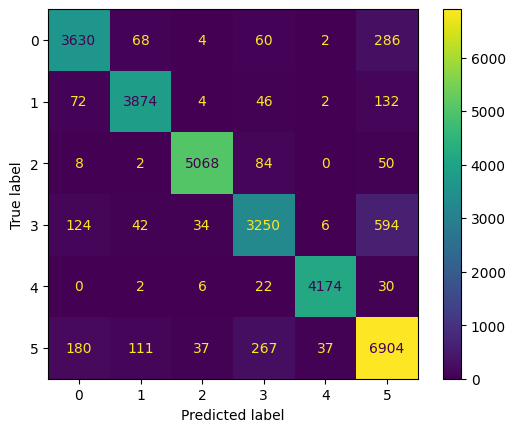

In [19]:
# Plot and save the averaged confusion matrix
confusion_matrix_display = ConfusionMatrixDisplay(
    confusion_matrix=all_confusion_matrices,
    display_labels=label_mapping.keys()
)
confusion_matrix_display.plot()
confusion_matrix_filename = "confusion_matrix_avg.png"
confusion_matrix_display.figure_.savefig(confusion_matrix_filename)
print(f"\nAveraged Confusion Matrix saved as {confusion_matrix_filename}")

In [ ]:
"""
model = BertForSequenceClassification.from_pretrained('./checkpoints')
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)
trainer.train(resume_from_checkpoint=True)
"""